In [9]:
import warnings
warnings.filterwarnings("ignore")
import numpy as np
from kdg import kdn, kdcnn
from kdg.utils import generate_gaussian_parity, hellinger, plot_2dsim, generate_ood_samples, sample_unifrom_circle
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
from joblib import Parallel, delayed
from scipy.io import savemat, loadmat
from sklearn.metrics import roc_auc_score
from tensorflow import keras
from tensorflow.keras.layers import Dense, Activation, Flatten, Conv2D, MaxPooling2D, BatchNormalization
from tensorflow.keras import activations
from tensorflow.keras import backend as bknd

### Visualize the data

<AxesSubplot: >

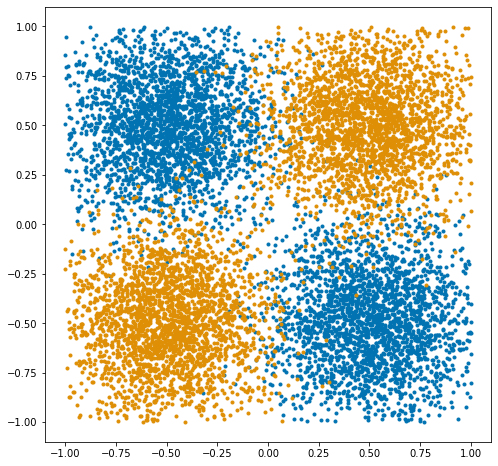

In [10]:
X, y = generate_gaussian_parity(10000)
plot_2dsim(X, y)

In [11]:
compile_kwargs = {
        "loss": "binary_crossentropy",
        "optimizer": keras.optimizers.Adam(3e-4),
    }
callback = keras.callbacks.EarlyStopping(monitor="loss", patience=10, verbose=True)
fit_kwargs = {
        "epochs": 200,
        "batch_size": 64,
        "verbose": False,
        "callbacks": [callback],
    }

In [12]:
# network architecture [10, 10, 10, 10, 2]
def getNN(input_size, num_classes):
    network_base = keras.Sequential()
    initializer = keras.initializers.random_normal(seed=0)
    network_base.add(keras.layers.Dense(2000, kernel_initializer=initializer, input_shape=(input_size,)))
    network_base.add(keras.layers.Activation(activations.relu))
    network_base.add(keras.layers.Dense(2000, kernel_initializer=initializer))
    network_base.add(keras.layers.Activation(activations.relu))
    network_base.add(keras.layers.Dense(2000, kernel_initializer=initializer))
    network_base.add(keras.layers.Activation(activations.relu))
    network_base.add(keras.layers.Dense(2000, kernel_initializer=initializer))
    network_base.add(keras.layers.Activation(activations.relu))
    network_base.add(keras.layers.Dense(units=num_classes, activation="softmax", kernel_initializer=initializer))
    network_base.compile(**compile_kwargs)
    return network_base

In [13]:
# train Vanilla NN
nn = getNN(input_size=2, num_classes=2)
history = nn.fit(X, keras.utils.to_categorical(y), **fit_kwargs)

2023-02-26 23:30:15.060252: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


Epoch 47: early stopping


### Calculate posteriors and likelihoods using KDN

In [ ]:
df = {}
model_kdn = kdn(k=.1, network=nn)
model_kdn.fit(X, y, epsilon=1e-4)

#define grids
p = np.arange(-3, 3, step=0.01)
q = np.arange(-3, 3, step=0.01)
xx, yy = np.meshgrid(p, q)

grid_samples = np.concatenate((xx.reshape(-1, 1), yy.reshape(-1, 1)), axis=1)
posterior_nn = model_kdn.network.predict(grid_samples)
posterior_kdn, likelihoods_kdn = model_kdn.predict_proba(grid_samples, return_likelihood=True)

posterior_nn = posterior_nn[:,0].reshape(600,600)
posterior_kdn = posterior_kdn[:,0].reshape(600,600)
class1_likelihoods = likelihoods_kdn[:,0].reshape(600,600)
class2_likelihoods = likelihoods_kdn[:,1].reshape(600,600)

df['posterior_dn'] = posterior_nn
df['posterior_kdn'] = posterior_kdn
df['likelihood_class1'] = class1_likelihoods
df['likelihood_class2'] = class2_likelihoods

[Parallel(n_jobs=-2)]: Using backend LokyBackend with 9 concurrent workers.


INFO:tensorflow:Assets written to: ram://22f1cbab-0d74-4a4a-9874-c5fa7e348785/assets
INFO:tensorflow:Assets written to: ram://36698e32-a440-4f72-9d07-d2ac271b1a02/assets
INFO:tensorflow:Assets written to: ram://d005d289-451d-42ce-aa1b-bae2069ebb3a/assets


2023-02-26 23:31:38.199538: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:305] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2023-02-26 23:31:38.199672: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:271] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)


Metal device set to: Apple M1 Max
INFO:tensorflow:Assets written to: ram://a0282fcd-6689-4491-a8ba-fb7fdfbf5940/assets
INFO:tensorflow:Assets written to: ram://0a26197f-e55b-43af-904b-e35120712981/assets
INFO:tensorflow:Assets written to: ram://31ce4306-3212-4afd-898e-c9bbb572fbc6/assets
INFO:tensorflow:Assets written to: ram://f19eb749-a10c-4172-9360-4af463f74c41/assets
INFO:tensorflow:Assets written to: ram://82f82b97-d03e-4931-9e25-5fee271121c4/assets
INFO:tensorflow:Assets written to: ram://07de4120-d758-439f-af3a-13734d7943b6/assets
Metal device set to: Apple M1 Max


2023-02-26 23:31:44.364182: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:305] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2023-02-26 23:31:44.364347: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:271] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)


INFO:tensorflow:Assets written to: ram://d18bebbd-d2f8-45bf-8bcb-8b8cc0c054cf/assets
INFO:tensorflow:Assets written to: ram://606321e8-292f-4e8b-9729-692c7ec0a853/assets
INFO:tensorflow:Assets written to: ram://a3a7d9d8-f3c5-4d92-aad0-68903871bf53/assets
INFO:tensorflow:Assets written to: ram://f9caf891-4634-41c2-bf60-da62a21e6107/assets
INFO:tensorflow:Assets written to: ram://408a4372-95cb-4ccd-a1e9-fd516da52f07/assets
INFO:tensorflow:Assets written to: ram://f78c94ea-e572-4084-a5d0-885d4198771d/assets
INFO:tensorflow:Assets written to: ram://049b9370-3d85-40ea-9d09-247a8532b992/assets
INFO:tensorflow:Assets written to: ram://6bc2e51a-4b9a-4d6c-801b-f57afe0b83a6/assets
INFO:tensorflow:Assets written to: ram://1b4d32d9-a517-4479-a044-5ad253b647e8/assets
INFO:tensorflow:Assets written to: ram://1710fe2b-8972-4397-87b8-2ceab591cf59/assets
INFO:tensorflow:Assets written to: ram://8547945e-1fe5-4784-90f0-c7cb50480ec6/assets
INFO:tensorflow:Assets written to: ram://f36db3b4-2584-47d5-bee0-

[Parallel(n_jobs=-2)]: Done  32 tasks      | elapsed:   36.9s


INFO:tensorflow:Assets written to: ram://27acb617-c098-4692-9a75-5f2a44a673f1/assets
INFO:tensorflow:Assets written to: ram://2d72418e-e06a-45a0-861f-fcc63068134d/assets
INFO:tensorflow:Assets written to: ram://2485f86f-6666-41e6-85ed-593dec0a966d/assets
INFO:tensorflow:Assets written to: ram://56fe4e0e-e2dd-432b-b005-20a41d6d661f/assets
INFO:tensorflow:Assets written to: ram://49c385d4-10b0-4355-97d9-94694df9782e/assets
INFO:tensorflow:Assets written to: ram://926a0caa-ca8c-41fa-ab00-e92ad1672b1e/assets
INFO:tensorflow:Assets written to: ram://ea222fe9-f308-4730-bdec-a8a4e70bb61d/assets
INFO:tensorflow:Assets written to: ram://19d479de-aea7-42ad-ae9c-db6b697681ff/assets
INFO:tensorflow:Assets written to: ram://ff85eb6c-92e6-4639-a680-94959e9fffdc/assets
INFO:tensorflow:Assets written to: ram://f62d3100-bce4-4732-bf64-a60c94a5b1cf/assets
INFO:tensorflow:Assets written to: ram://e2206975-ca00-4854-9378-f7fa2e9f54fa/assets
INFO:tensorflow:Assets written to: ram://6308f1dc-f501-4537-88a2-

INFO:tensorflow:Assets written to: ram://99aad833-ad4a-418a-a848-016b58497d4a/assets
INFO:tensorflow:Assets written to: ram://7f4d71ae-f857-4c3e-a488-280069168535/assets
INFO:tensorflow:Assets written to: ram://60318303-a399-43fa-9bc3-2215e31bcacd/assets
INFO:tensorflow:Assets written to: ram://dc37503a-ca86-42ad-999f-6fd8b97341f5/assets
INFO:tensorflow:Assets written to: ram://a482f055-6a19-4c21-bcb3-4a15273ec79e/assets
INFO:tensorflow:Assets written to: ram://145848dc-a7a1-458c-9644-75eb48d0d1bc/assets
INFO:tensorflow:Assets written to: ram://5fdef549-ad64-4225-9613-20e73d0c9a9a/assets
INFO:tensorflow:Assets written to: ram://414d2e35-d22e-4570-9a6d-d9f4e5dad6e8/assets
INFO:tensorflow:Assets written to: ram://5c60a822-ed9d-4514-a84e-a71d66a0e8ae/assets
INFO:tensorflow:Assets written to: ram://76851750-096b-4ac6-8e0b-e02ff50a5e8d/assets
INFO:tensorflow:Assets written to: ram://1cf30864-f9f4-4197-903c-61dc6dc8b2ae/assets
INFO:tensorflow:Assets written to: ram://9f24a93a-080b-4ec5-b1ca-

[Parallel(n_jobs=-2)]: Done 182 tasks      | elapsed:  3.2min


INFO:tensorflow:Assets written to: ram://40f3b0ad-4d23-420c-9d77-43ff6567f1ea/assets
INFO:tensorflow:Assets written to: ram://59c9a50b-9f77-4c89-99a9-b8d14f48412c/assets
INFO:tensorflow:Assets written to: ram://b2e6b924-faec-4a6c-8f44-0cfb2446b751/assets
INFO:tensorflow:Assets written to: ram://02b8dd2b-9e4b-46ea-b9ca-0e0a2672259a/assets
INFO:tensorflow:Assets written to: ram://7841cb2a-f947-4573-bcfe-26cc435f4b8e/assets
INFO:tensorflow:Assets written to: ram://170c05e8-8e3e-44dc-907a-c1a42e3f8f30/assets
INFO:tensorflow:Assets written to: ram://4be77402-8510-4d00-b1eb-a65199255709/assets
INFO:tensorflow:Assets written to: ram://e5b2f0b7-bc10-4001-964b-d8bcc400ebb4/assets
INFO:tensorflow:Assets written to: ram://2cad742b-c52f-4c99-bec3-c430abd88ad9/assets
INFO:tensorflow:Assets written to: ram://0d27fb06-3343-4435-9923-2e0cd0ea4b4a/assets
INFO:tensorflow:Assets written to: ram://717a65cd-cec2-4bd2-a476-69edb1858937/assets
INFO:tensorflow:Assets written to: ram://eba53f34-e3e8-485f-a708-

INFO:tensorflow:Assets written to: ram://c7be6980-4aee-46bc-9c19-8a59987f783a/assets
INFO:tensorflow:Assets written to: ram://e76d94dd-50b8-4b15-b5b2-5c8565c9f98d/assets
INFO:tensorflow:Assets written to: ram://1bb939c6-c773-4a49-9027-c2645a786daf/assets
INFO:tensorflow:Assets written to: ram://2e953156-5ebe-4386-b3cc-434d6766998b/assets
INFO:tensorflow:Assets written to: ram://d0667e10-b9c8-45ba-a24b-51bcaa4c84cc/assets
INFO:tensorflow:Assets written to: ram://a2f2f55c-f2ce-44e3-b476-e1f673cded73/assets
INFO:tensorflow:Assets written to: ram://748e6e24-78a7-403d-92c0-ccabcab0780b/assets
INFO:tensorflow:Assets written to: ram://46e5ed1a-b699-457d-a301-cb36e8c16ab9/assets
INFO:tensorflow:Assets written to: ram://64460453-5ca9-493c-ae69-3935e75c550e/assets
INFO:tensorflow:Assets written to: ram://211299c7-7b0b-4152-b0e9-d78339102bfd/assets
INFO:tensorflow:Assets written to: ram://137e45ea-a774-4302-a618-ffec293d3886/assets
INFO:tensorflow:Assets written to: ram://ad2dbece-5b54-412a-9ca1-

INFO:tensorflow:Assets written to: ram://e6da46a6-a65d-486c-b2ff-7d8a3e187541/assets
INFO:tensorflow:Assets written to: ram://b5f93e61-91f2-4433-90ac-de252fb03165/assets
INFO:tensorflow:Assets written to: ram://0164a57a-49fa-4eea-adbb-429cf60f9fae/assets
INFO:tensorflow:Assets written to: ram://c02c32ab-df91-4d57-8402-0eb5dde5d1a0/assets
INFO:tensorflow:Assets written to: ram://929df611-f183-461e-bf12-46172f51aa15/assets
INFO:tensorflow:Assets written to: ram://67a69d3f-4cd9-4872-bfff-b9cc82281720/assets
INFO:tensorflow:Assets written to: ram://2b2f60a3-3d99-4f54-b4da-5aa9493cbad5/assets
INFO:tensorflow:Assets written to: ram://d29022cf-46f1-4339-8c8c-697a685649fd/assets
INFO:tensorflow:Assets written to: ram://feef3e61-323b-4e72-85d1-f6adddb9a912/assets
INFO:tensorflow:Assets written to: ram://ee7bb80e-7c93-49ae-b9aa-3023b1b8a607/assets
INFO:tensorflow:Assets written to: ram://3eabeafb-c574-4537-81ff-87234e91f703/assets
INFO:tensorflow:Assets written to: ram://8f29b9df-9879-43d8-991d-

[Parallel(n_jobs=-2)]: Done 432 tasks      | elapsed:  7.6min


INFO:tensorflow:Assets written to: ram://8c85b120-a91c-4e3f-92e6-d4ade3afe952/assets
INFO:tensorflow:Assets written to: ram://a4d19db3-3718-47f7-9edb-774d7dc191b2/assets
INFO:tensorflow:Assets written to: ram://fb869c4b-fd01-4e47-9109-d043ee0efd9a/assets
INFO:tensorflow:Assets written to: ram://f3ced35d-3a59-4943-9ffe-dbed57b03f07/assets
INFO:tensorflow:Assets written to: ram://092ecd38-98f2-4f01-a3e0-e042676ea503/assets
INFO:tensorflow:Assets written to: ram://9921bbf0-8a04-4f30-b622-cffb4ec6a6b1/assets
INFO:tensorflow:Assets written to: ram://1e1bca87-da8a-4344-a2f7-9e65e084632a/assets
INFO:tensorflow:Assets written to: ram://44df6e4b-07f8-481e-b83a-51b5a8d9861b/assets
INFO:tensorflow:Assets written to: ram://8e679fc3-0554-42ce-8485-b5ca6dbcbca9/assets
INFO:tensorflow:Assets written to: ram://d63dc23f-686a-452d-ac11-863d0de9d90c/assets
INFO:tensorflow:Assets written to: ram://86f4613a-dd01-4615-b742-23b6aff8d8f0/assets
INFO:tensorflow:Assets written to: ram://1116de6a-3b31-4b0e-b224-

INFO:tensorflow:Assets written to: ram://69916a49-907e-4fc2-9289-af4afa667ec7/assets
INFO:tensorflow:Assets written to: ram://820401bd-7e52-4dc4-b125-c0ce6a8078df/assets
INFO:tensorflow:Assets written to: ram://a4c9ea18-b71b-4faf-bb82-037a0092a215/assets
INFO:tensorflow:Assets written to: ram://6b0f5a8e-3d0d-4ce6-8d47-1aa8335e2353/assets
INFO:tensorflow:Assets written to: ram://441377e4-9b44-42d9-81bb-701bfcc52831/assets
INFO:tensorflow:Assets written to: ram://aa3bcdcc-cf13-4648-abd2-5751afc4416a/assets
INFO:tensorflow:Assets written to: ram://1841d246-6939-44a0-9ec8-8088b29a0988/assets
INFO:tensorflow:Assets written to: ram://90240c1c-fe08-4c84-a16e-019a28b8f667/assets
INFO:tensorflow:Assets written to: ram://d8d1d78a-649d-4c91-b9b3-5cd6202dec9b/assets
INFO:tensorflow:Assets written to: ram://d00a752e-66f0-4a45-bc7c-5498ab298ed2/assets
INFO:tensorflow:Assets written to: ram://4d3381a4-85b4-43f2-a1cd-4ab851e459a9/assets
INFO:tensorflow:Assets written to: ram://75102e93-a18a-4e4e-8402-

INFO:tensorflow:Assets written to: ram://d49948dd-d99c-4d1a-a4e2-3cdfd8667098/assets
INFO:tensorflow:Assets written to: ram://4259b58e-fb2c-4e3a-81e5-d4511e6b791d/assets
INFO:tensorflow:Assets written to: ram://6cd79422-b696-4196-8658-c22e4327bf79/assets
INFO:tensorflow:Assets written to: ram://f327019a-dcee-4e2c-a5d7-e9bc220abc12/assets
INFO:tensorflow:Assets written to: ram://11a91547-21c9-4336-b259-5b814f90eb59/assets
INFO:tensorflow:Assets written to: ram://caa989f0-1231-4c1e-b828-74c5f02a66bb/assets
INFO:tensorflow:Assets written to: ram://bcda241d-0372-4c67-ae01-0c48a4a81d6a/assets
INFO:tensorflow:Assets written to: ram://70f10a0c-2b0a-4a0a-9ef3-39b76ab9f16a/assets
INFO:tensorflow:Assets written to: ram://adb2758a-58af-4efa-aefc-32dc1237c36b/assets
INFO:tensorflow:Assets written to: ram://6cad211f-b739-4c97-85e8-509f26c3b339/assets
INFO:tensorflow:Assets written to: ram://62add4d7-6490-4999-93bc-e241823cdfd2/assets
INFO:tensorflow:Assets written to: ram://fea81650-6674-41a6-8efc-

INFO:tensorflow:Assets written to: ram://f18c6fd2-981a-4539-bcdf-7e77b8b4468c/assets
INFO:tensorflow:Assets written to: ram://40450cba-ae76-4e46-bbcd-0acf0ded291b/assets
INFO:tensorflow:Assets written to: ram://7b8605d1-ff0b-4878-88b7-90e87b0eb492/assets
INFO:tensorflow:Assets written to: ram://6ef7300d-5855-4087-aa1a-d7eebfdaf102/assets
INFO:tensorflow:Assets written to: ram://f238d199-3b83-4856-9d93-93c630678c97/assets
INFO:tensorflow:Assets written to: ram://4d3f4b92-72a6-44e5-b626-9bc754782757/assets
INFO:tensorflow:Assets written to: ram://fcd4a7f7-4aec-4e72-b71d-9952379aee8d/assets
INFO:tensorflow:Assets written to: ram://b1cb4c47-3442-4dad-8439-bf8469ce89c0/assets
INFO:tensorflow:Assets written to: ram://112a750f-a345-4bf2-9f4f-356702392d00/assets
INFO:tensorflow:Assets written to: ram://25f705ee-89f0-4daf-ab08-6a27cfdb9fb8/assets
INFO:tensorflow:Assets written to: ram://6125cf31-1c1e-4647-9152-f4e90fc04492/assets
INFO:tensorflow:Assets written to: ram://aa48bade-6b30-4a87-add5-

[Parallel(n_jobs=-2)]: Done 782 tasks      | elapsed: 13.6min


INFO:tensorflow:Assets written to: ram://ced2bca8-66b1-4ad5-a6cd-db158c9d201d/assets
INFO:tensorflow:Assets written to: ram://970b0d13-d1b7-445b-8595-87825f5acc8a/assets
INFO:tensorflow:Assets written to: ram://f2ebb534-b78d-47c7-b14c-8214340960cf/assets
INFO:tensorflow:Assets written to: ram://d064fc5a-badf-496c-ab0e-16f312f33f30/assets
INFO:tensorflow:Assets written to: ram://318416de-ffbd-4c3d-94bb-00e073763dfd/assets
INFO:tensorflow:Assets written to: ram://23abd9ef-fab0-418f-960d-dde02a05778c/assets
INFO:tensorflow:Assets written to: ram://13a99684-5ba7-4280-89c5-c0f05b0fa382/assets
INFO:tensorflow:Assets written to: ram://6a10d69b-1ef8-4e5f-815e-b7cd04b93b87/assets
INFO:tensorflow:Assets written to: ram://00ab45e9-4efc-4c35-9303-c5c7e1fe37f2/assets
INFO:tensorflow:Assets written to: ram://0f243ccf-721e-46bc-ac1a-d6902c133ac6/assets
INFO:tensorflow:Assets written to: ram://eb4a7d64-0bad-469a-99ce-10083fd439ef/assets
INFO:tensorflow:Assets written to: ram://88d7bcae-cf45-4fa6-a8bb-

INFO:tensorflow:Assets written to: ram://d52864e5-2116-4bcf-9b0d-a78ad210e436/assets
INFO:tensorflow:Assets written to: ram://4bb70bb5-b936-43f3-8ac4-74073d7cb9c1/assets
INFO:tensorflow:Assets written to: ram://9df8d5b7-cad8-4107-835b-12f45046e0c1/assets
INFO:tensorflow:Assets written to: ram://e2b6533a-d9e6-4901-bd5c-ae6313af4c4e/assets
INFO:tensorflow:Assets written to: ram://8e710a71-5b3a-4189-8353-eb40e8e3d45f/assets
INFO:tensorflow:Assets written to: ram://8388e007-f794-4f4a-9be4-7beb8d7269e2/assets
INFO:tensorflow:Assets written to: ram://a087882b-19d6-4ead-8024-09cb3e041546/assets
INFO:tensorflow:Assets written to: ram://eeea4111-c0c9-4ff7-9f89-f2615196697a/assets
INFO:tensorflow:Assets written to: ram://81f5ecbe-336b-42ae-8861-fae1cc372e48/assets
INFO:tensorflow:Assets written to: ram://a9a1746b-0d15-44af-9a56-0c713f0a0058/assets
INFO:tensorflow:Assets written to: ram://d054d79b-12d0-4966-b56c-76295f2701e9/assets
INFO:tensorflow:Assets written to: ram://4323778e-4373-4749-9e11-

INFO:tensorflow:Assets written to: ram://ca7d0986-c388-416f-9c54-077b26928cd8/assets
INFO:tensorflow:Assets written to: ram://eef712e3-c5c3-497b-8b0e-e6bf1f578978/assets
INFO:tensorflow:Assets written to: ram://117d0e8f-53b1-4f9c-84f8-9e685f68dfac/assets
INFO:tensorflow:Assets written to: ram://cd68a728-baf1-486c-9e42-a3bc6be1240b/assets
INFO:tensorflow:Assets written to: ram://059459fb-7dd7-4844-9b66-9b691a64b44b/assets
INFO:tensorflow:Assets written to: ram://d85e0128-2e20-4df7-938c-b78cd2bed6f2/assets
INFO:tensorflow:Assets written to: ram://596c1973-78b1-4e3a-918a-7762472e114c/assets
INFO:tensorflow:Assets written to: ram://58ffbe20-fae9-48b9-80d0-c219c3bf437e/assets
INFO:tensorflow:Assets written to: ram://b8b339a8-eb6a-4e41-8a04-170e73581800/assets
INFO:tensorflow:Assets written to: ram://2f0e4c36-aac9-4a6c-a229-794fd758d1b1/assets
INFO:tensorflow:Assets written to: ram://d83c1ba9-df7d-419c-88fe-faeea61dfa50/assets
INFO:tensorflow:Assets written to: ram://c1f67fd6-2ca0-4b19-9fdb-

INFO:tensorflow:Assets written to: ram://c1d81ed3-cbf6-4e49-b3d9-2b7fa502745e/assets
INFO:tensorflow:Assets written to: ram://680f7822-00b9-4c43-8ce2-e355662f0fc6/assets
INFO:tensorflow:Assets written to: ram://2433b46a-ee45-4bcc-b839-be45fe44d675/assets
INFO:tensorflow:Assets written to: ram://d1857750-6103-4570-b5e6-d6f337234b93/assets
INFO:tensorflow:Assets written to: ram://91e75e5b-6761-4cb5-9a3b-61349ba9c162/assets
INFO:tensorflow:Assets written to: ram://e78baa21-704a-40fd-8b09-56a7713ef185/assets
INFO:tensorflow:Assets written to: ram://18793fed-4b41-4480-ab50-70f24c4b6cac/assets
INFO:tensorflow:Assets written to: ram://ed9146ec-7bef-41dd-b515-46843b4f4be7/assets
INFO:tensorflow:Assets written to: ram://e5356183-ce59-463d-9bed-91e54fdc107f/assets
INFO:tensorflow:Assets written to: ram://cab3d54c-8562-487e-9218-26d20b90fc92/assets
INFO:tensorflow:Assets written to: ram://7d5f0a19-9b07-4f46-b028-c99cf62e5e3f/assets
INFO:tensorflow:Assets written to: ram://6b0f5eee-e942-4044-933f-

INFO:tensorflow:Assets written to: ram://e82d5dd3-80be-4d50-b2de-57e0aeed17f7/assets
INFO:tensorflow:Assets written to: ram://df7b272a-678d-410b-99ca-e3ca58bf5194/assets
INFO:tensorflow:Assets written to: ram://f92c5873-c5b2-46b7-b954-a81960ff359c/assets
INFO:tensorflow:Assets written to: ram://3e85579b-e75c-4de0-9575-d40e7fe4e9da/assets
INFO:tensorflow:Assets written to: ram://121db53d-eb6d-4f6f-8e1c-14d45387e321/assets
INFO:tensorflow:Assets written to: ram://019540ea-0aa4-4e44-bebd-28d479738748/assets
INFO:tensorflow:Assets written to: ram://cfb700a2-ef14-423f-b759-d97f1152baed/assets
INFO:tensorflow:Assets written to: ram://e64ff7a2-ff2b-42b0-8117-e2e592f65763/assets
INFO:tensorflow:Assets written to: ram://a00d7d54-09ff-43c7-856d-db2c02e428b3/assets
INFO:tensorflow:Assets written to: ram://19b89680-bd6a-4529-bbb4-970440f98e8e/assets
INFO:tensorflow:Assets written to: ram://ce72f203-594e-4605-8943-8e26de9cab9b/assets
INFO:tensorflow:Assets written to: ram://0ca9b6a1-7d9c-4e82-8f3f-

[Parallel(n_jobs=-2)]: Done 1232 tasks      | elapsed: 21.5min


INFO:tensorflow:Assets written to: ram://ee8514f3-f291-4d8d-8583-b85c4374e4bf/assets
INFO:tensorflow:Assets written to: ram://15e52c37-1ac8-49f4-890f-d6e6f5b10db4/assets
INFO:tensorflow:Assets written to: ram://876a4c8a-d1d9-4c44-81f4-ad947ad7f3ce/assets
INFO:tensorflow:Assets written to: ram://c412516c-bd34-46ed-a9e2-abfb259e549d/assets
INFO:tensorflow:Assets written to: ram://08f3e74a-1600-4a98-a865-42fd885d8dae/assets
INFO:tensorflow:Assets written to: ram://bd73997d-75bf-4108-9876-a9100dcb3b1b/assets
INFO:tensorflow:Assets written to: ram://5567c657-bd76-4f2e-83d7-49dae5dc817b/assets
INFO:tensorflow:Assets written to: ram://bcc29371-6698-4e41-8d23-2fd5862ab3f3/assets
INFO:tensorflow:Assets written to: ram://6bb3d184-3d08-45fa-9332-2c850e7981a4/assets
INFO:tensorflow:Assets written to: ram://75c71fdf-fa6a-40f3-8f19-022951ccebc0/assets
INFO:tensorflow:Assets written to: ram://fc530810-ceda-4b59-81ca-b787aac9eaa0/assets
INFO:tensorflow:Assets written to: ram://9ec9014b-5a98-4f83-b79e-

INFO:tensorflow:Assets written to: ram://a476ca5a-0a93-4fcb-a8b1-dbef811f726f/assets
INFO:tensorflow:Assets written to: ram://c33ea125-6c7e-4216-a6d1-6b53f69ae22b/assets
INFO:tensorflow:Assets written to: ram://355aab90-b204-43b4-8bf5-f4101cac7fb6/assets
INFO:tensorflow:Assets written to: ram://2654455a-6da3-4c13-974c-fe133967bf67/assets
INFO:tensorflow:Assets written to: ram://3bbae2de-a035-413b-a6ec-e33be8e28628/assets
INFO:tensorflow:Assets written to: ram://00fb6d8f-6c0a-4f60-9d01-ce94618e4a53/assets
INFO:tensorflow:Assets written to: ram://18c604a5-72a1-4c9c-915c-d3a1b0d5c8f2/assets
INFO:tensorflow:Assets written to: ram://1856f796-03b3-4df7-be5c-4dc18f3c6e32/assets
INFO:tensorflow:Assets written to: ram://4d027618-dafa-448a-9c37-1af887377bf2/assets
INFO:tensorflow:Assets written to: ram://9b6d92d0-1e08-4ce7-b4a5-d54243d8bcb2/assets
INFO:tensorflow:Assets written to: ram://5b8e9088-e659-48e4-991b-a0291ee36804/assets
INFO:tensorflow:Assets written to: ram://edadec9c-67f8-42ad-9daf-

INFO:tensorflow:Assets written to: ram://fbd9ee06-caa1-41bd-a74b-f3eb3e6f6866/assets
INFO:tensorflow:Assets written to: ram://0d896790-d03f-42c7-8641-ad2f86840e56/assets
INFO:tensorflow:Assets written to: ram://1c61d5e3-2109-4056-8bab-da402dbfd574/assets
INFO:tensorflow:Assets written to: ram://0a918e31-47b0-49a4-b0c3-680a138dedee/assets
INFO:tensorflow:Assets written to: ram://8cafc292-2c16-48c3-963f-8aaa89adee34/assets
INFO:tensorflow:Assets written to: ram://90f1579a-f1f3-4c0b-9da4-c19646e34c36/assets
INFO:tensorflow:Assets written to: ram://e98a3bdc-ab88-4973-8e24-ac93aeebda18/assets
INFO:tensorflow:Assets written to: ram://c43fe991-b0a0-4327-a647-fc1d3528a2b8/assets
INFO:tensorflow:Assets written to: ram://eb45c41f-6d7f-4b35-bd34-f4061cee9ab4/assets
INFO:tensorflow:Assets written to: ram://109c0be5-cc03-4ce1-9a8a-407f4d1f3c27/assets
INFO:tensorflow:Assets written to: ram://5b4d681d-b976-49ae-8593-ae2a6abc921f/assets
INFO:tensorflow:Assets written to: ram://a289d33f-25ee-4df6-a543-

INFO:tensorflow:Assets written to: ram://446c842b-42c8-48fd-ae8e-57db23701e91/assets
INFO:tensorflow:Assets written to: ram://5876a8e3-cb72-44f8-b794-fa924f26b252/assets
INFO:tensorflow:Assets written to: ram://28386e60-8981-4b46-bb53-bd33c194a93d/assets
INFO:tensorflow:Assets written to: ram://0ed89cd1-aa41-4414-b9c7-ffdc3f05c509/assets
INFO:tensorflow:Assets written to: ram://261da06b-1d39-49f9-8751-54254450ace9/assets
INFO:tensorflow:Assets written to: ram://77fd3fe3-d400-4485-8ad6-4a1d5029755e/assets
INFO:tensorflow:Assets written to: ram://865c43e5-1042-456a-a18b-55ffd2511510/assets
INFO:tensorflow:Assets written to: ram://8556b9ad-1098-4d4d-92ac-b6ab48914706/assets
INFO:tensorflow:Assets written to: ram://14886b51-abbb-4764-a4a2-8330af53bb63/assets
INFO:tensorflow:Assets written to: ram://68cb89b8-f092-49d3-b572-1add017323c9/assets
INFO:tensorflow:Assets written to: ram://b1e34b38-e563-4d8d-85a2-41d97a0596e5/assets
INFO:tensorflow:Assets written to: ram://bf606c08-0e9d-43a6-87da-

INFO:tensorflow:Assets written to: ram://d06f7a0d-7633-4cd5-90d2-83f3f6be8f8e/assets
INFO:tensorflow:Assets written to: ram://6a417fa5-3f72-4560-82f4-978eeab4051e/assets
INFO:tensorflow:Assets written to: ram://f504e644-1127-44ad-b3dd-6b167ee40945/assets
INFO:tensorflow:Assets written to: ram://639afd16-0690-4cd1-b1b8-23675f24ab39/assets
INFO:tensorflow:Assets written to: ram://d2056535-c126-4eab-8f1a-02f63061cc7d/assets
INFO:tensorflow:Assets written to: ram://eac85b23-8fe6-49ec-ba68-0108b8aee9e1/assets
INFO:tensorflow:Assets written to: ram://0e7226f6-01ee-4dbc-be0a-b5c3a3eb8eab/assets
INFO:tensorflow:Assets written to: ram://f9568104-be51-4519-aeb0-eb06b13cada7/assets
INFO:tensorflow:Assets written to: ram://5ec4f6da-c289-4ba6-8599-0be12309fb07/assets
INFO:tensorflow:Assets written to: ram://c294b467-aa92-479d-8b67-6421a195e72b/assets
INFO:tensorflow:Assets written to: ram://13869783-ab15-4406-bac7-d3aa0b1f6612/assets
INFO:tensorflow:Assets written to: ram://4d3e4b3e-3c18-4f80-8179-

INFO:tensorflow:Assets written to: ram://40245c60-ed68-4320-811c-d6191e7e00a2/assets
INFO:tensorflow:Assets written to: ram://e3459328-3822-4f02-8023-a1a75dd62283/assets
INFO:tensorflow:Assets written to: ram://a3457f94-d669-4e1e-bdc2-c551fc68550a/assets
INFO:tensorflow:Assets written to: ram://6db6ab82-1f36-40b6-af02-d786df37f883/assets
INFO:tensorflow:Assets written to: ram://a261e197-19ff-4f56-ab43-f4b811b882ba/assets
INFO:tensorflow:Assets written to: ram://2698ff37-8f5f-4661-8ead-c9e54942d9b3/assets
INFO:tensorflow:Assets written to: ram://069e36d1-ed7a-45a2-84f5-8f8c95c86a1f/assets
INFO:tensorflow:Assets written to: ram://610d5443-2cf7-4788-adaa-fd6e0573be83/assets
INFO:tensorflow:Assets written to: ram://17e02dc7-b361-48fc-bc52-40f587bc5041/assets
INFO:tensorflow:Assets written to: ram://cd752d0e-1b94-41f9-997e-79da6d73e1a0/assets
INFO:tensorflow:Assets written to: ram://e254b9f8-2e8a-4a78-83cb-25bf4119c1a4/assets
INFO:tensorflow:Assets written to: ram://99cd54b8-82f1-4f0f-8f40-

[Parallel(n_jobs=-2)]: Done 1782 tasks      | elapsed: 31.2min


INFO:tensorflow:Assets written to: ram://a39e4bcb-b4e3-4dcb-9148-8e6528b94ef2/assets
INFO:tensorflow:Assets written to: ram://0fa1ec61-bc8d-4c9e-9467-58091264664d/assets
INFO:tensorflow:Assets written to: ram://addf72a5-dcef-4e3e-ab0a-4f42ad2873d3/assets
INFO:tensorflow:Assets written to: ram://8dccea83-0b84-4416-adb1-0b534de72330/assets
INFO:tensorflow:Assets written to: ram://f9b77abf-c064-4408-b4e6-b9a880091bb7/assets
INFO:tensorflow:Assets written to: ram://9c300b12-1061-4ebc-80d7-feff34c38005/assets
INFO:tensorflow:Assets written to: ram://0cef24e8-bbdd-450a-868c-d14f913b90ba/assets
INFO:tensorflow:Assets written to: ram://a60aeb83-9de3-47b7-a7b8-7c547eab746c/assets
INFO:tensorflow:Assets written to: ram://6f65d326-f0e3-41cc-9e54-00db6442f63a/assets
INFO:tensorflow:Assets written to: ram://1276b33f-8805-421e-8a93-a71669bb2a5e/assets
INFO:tensorflow:Assets written to: ram://50701544-b1a2-4a6e-b808-0b1b9df8b6b5/assets
INFO:tensorflow:Assets written to: ram://a550c3f1-d0ae-43db-b097-

INFO:tensorflow:Assets written to: ram://423b2085-dc4b-4468-bf8a-182012bac4be/assets
INFO:tensorflow:Assets written to: ram://2cdb7f82-75cb-4129-902a-86330c428dfa/assets
INFO:tensorflow:Assets written to: ram://a49693e0-f94b-43f7-aa5d-dd8df6da2976/assets
INFO:tensorflow:Assets written to: ram://e7b1647c-7da8-4863-ab9a-7fb7c3371977/assets
INFO:tensorflow:Assets written to: ram://8e30fdfa-f3be-403d-ba25-f8f75d4fba49/assets
INFO:tensorflow:Assets written to: ram://9dd68e7f-ecb5-46a5-9ad6-1a35dfe25b86/assets
INFO:tensorflow:Assets written to: ram://9b621035-9ab4-479a-8570-3df753ee0edd/assets
INFO:tensorflow:Assets written to: ram://6199c975-95d3-4b50-af24-41966d245dfd/assets
INFO:tensorflow:Assets written to: ram://5551d318-2fe0-4713-8e7e-c5d6551d36d7/assets
INFO:tensorflow:Assets written to: ram://0c740de4-85da-454b-92a9-bad6b9a43c33/assets
INFO:tensorflow:Assets written to: ram://9b0c6922-bbba-459b-b8f4-0ceb3269255e/assets
INFO:tensorflow:Assets written to: ram://e9490e56-17ec-463a-a54b-

INFO:tensorflow:Assets written to: ram://698e9bed-c978-4733-80be-918127ec8768/assets
INFO:tensorflow:Assets written to: ram://c1e4848f-d1db-407f-8b2f-82cbc66f9799/assets
INFO:tensorflow:Assets written to: ram://42f4cc45-a578-4158-9d6c-30caa9a9e979/assets
INFO:tensorflow:Assets written to: ram://f48dbf8d-9d82-42c6-8bf6-c7ce806307c4/assets
INFO:tensorflow:Assets written to: ram://c9a4faf6-f3f0-4ebe-9f99-26268c8f0f02/assets
INFO:tensorflow:Assets written to: ram://734a99d0-79cd-4aef-9d51-183dc35b65ed/assets
INFO:tensorflow:Assets written to: ram://aca62671-72ee-4a6d-b80e-2e91c69adbf4/assets
INFO:tensorflow:Assets written to: ram://808eb56f-fcff-402e-a108-2ab30594a317/assets
INFO:tensorflow:Assets written to: ram://f05322f1-d36c-496a-a275-2d7f07b2eea2/assets
INFO:tensorflow:Assets written to: ram://dd831d2b-0d01-40f1-b35a-6028e67c8a5b/assets
INFO:tensorflow:Assets written to: ram://08b6b81e-41c5-4eed-b0a0-85f9c8dc0567/assets
INFO:tensorflow:Assets written to: ram://b8ac75b1-0644-4b74-b76f-

INFO:tensorflow:Assets written to: ram://382c7015-df06-4bf2-91ac-b88e0b4e6b6b/assets
INFO:tensorflow:Assets written to: ram://e08dc784-db8d-4756-9692-236ba2a026c1/assets
INFO:tensorflow:Assets written to: ram://b5775dac-89e6-4894-8809-243039d623af/assets
INFO:tensorflow:Assets written to: ram://ee20303d-ed52-4f74-8a4f-aef812b33617/assets
INFO:tensorflow:Assets written to: ram://6a9b6c85-ca19-4981-b59a-ce98cc606c2f/assets
INFO:tensorflow:Assets written to: ram://f93822b9-458d-43c0-896d-36f3a98b7248/assets
INFO:tensorflow:Assets written to: ram://87623666-06d0-4228-ae90-a81452cbe661/assets
INFO:tensorflow:Assets written to: ram://bfe4dc84-0c6f-4af4-aba4-059d648b7114/assets
INFO:tensorflow:Assets written to: ram://9d2c283b-24a0-4d16-8c5a-3253ebeccc81/assets
INFO:tensorflow:Assets written to: ram://0f6f7004-8613-4aa8-b96f-cbd329194109/assets
INFO:tensorflow:Assets written to: ram://b74d1595-77e4-4ae8-b7d5-f845f113b8d7/assets
INFO:tensorflow:Assets written to: ram://47178136-77a3-43c8-a464-

INFO:tensorflow:Assets written to: ram://8eb0c031-2c13-431e-a140-fe7e8faf4a02/assets
INFO:tensorflow:Assets written to: ram://8319ff67-f3d5-454c-8489-5720693bd23b/assets
INFO:tensorflow:Assets written to: ram://da013d55-9f41-4667-bb4f-a62fd2d7c7bd/assets
INFO:tensorflow:Assets written to: ram://18b3e8ac-7906-42db-986b-199cdf3ae4c0/assets
INFO:tensorflow:Assets written to: ram://9f33b679-3fd8-4c53-81a8-c1a2b801dd25/assets
INFO:tensorflow:Assets written to: ram://a54c6a35-6356-4d6c-9e0b-cdeab79f0949/assets
INFO:tensorflow:Assets written to: ram://d1ff4f6c-ad97-4c4f-9ec7-cd4c3cce5540/assets
INFO:tensorflow:Assets written to: ram://fa03a349-38b5-431b-8f20-a11a6e840b17/assets
INFO:tensorflow:Assets written to: ram://76c6acab-73aa-4cde-a146-f68077eb489b/assets
INFO:tensorflow:Assets written to: ram://09db5a3d-e77d-47ab-9bc9-b8bf1d63dc5f/assets
INFO:tensorflow:Assets written to: ram://2d43364f-e25f-47f8-b4c9-e3a7fc6c1cb8/assets
INFO:tensorflow:Assets written to: ram://83e5df7b-495c-43df-9e8b-

INFO:tensorflow:Assets written to: ram://58feb7c6-acad-4ca3-8e6f-a5973b2544a2/assets
INFO:tensorflow:Assets written to: ram://69671dd6-d522-42ed-9084-19fd8ac561da/assets
INFO:tensorflow:Assets written to: ram://b4cec4dd-d39e-487b-b7c1-d58e2620b9cb/assets
INFO:tensorflow:Assets written to: ram://a8c24bb4-3d2e-4a5a-b451-9a480eccefc7/assets
INFO:tensorflow:Assets written to: ram://5109ab05-4688-4e8c-8ce2-9e9638b12f8a/assets
INFO:tensorflow:Assets written to: ram://2639fbb8-ad59-4fe7-a678-c12bac088748/assets
INFO:tensorflow:Assets written to: ram://76844310-d432-48ae-a4f9-1b1e76ab67b1/assets
INFO:tensorflow:Assets written to: ram://7f6576b0-7531-49dc-a31b-d7ff7653f007/assets
INFO:tensorflow:Assets written to: ram://75c1916c-0716-401e-94ea-a3ff2110f9eb/assets
INFO:tensorflow:Assets written to: ram://8ff514b5-0734-4c7d-aea9-c0b39278d082/assets
INFO:tensorflow:Assets written to: ram://84885660-cc30-4b31-96cf-0268f1cc7165/assets
INFO:tensorflow:Assets written to: ram://67a5f6e0-a488-4d8d-93a2-

INFO:tensorflow:Assets written to: ram://2458736a-5c48-46d7-817e-c35955288d22/assets
INFO:tensorflow:Assets written to: ram://805b6081-fa44-424a-90b0-098a2495f9e5/assets
INFO:tensorflow:Assets written to: ram://e0fe4fc5-96bd-4923-96e3-cf5e0ba303e5/assets
INFO:tensorflow:Assets written to: ram://6c5c718f-39dd-4bb3-9420-4744c9d1d0e7/assets
INFO:tensorflow:Assets written to: ram://ccbead9b-e3fb-4e27-97cd-3776b2620cb7/assets
INFO:tensorflow:Assets written to: ram://35cd291f-7203-4a74-a418-0612c572f7f8/assets
INFO:tensorflow:Assets written to: ram://9e1e008e-d549-4f12-9ffc-08a45ea19e9c/assets
INFO:tensorflow:Assets written to: ram://916d6fec-15a7-4e10-9ccc-bd406642db60/assets
INFO:tensorflow:Assets written to: ram://27e401b1-cc27-4996-b52b-48e6df6b7719/assets
INFO:tensorflow:Assets written to: ram://fd018795-6241-4c04-8dab-a31c540423f7/assets
INFO:tensorflow:Assets written to: ram://6e0bf84b-2476-41a0-8f1e-bdf60f949fad/assets
INFO:tensorflow:Assets written to: ram://f84f5274-78e4-495a-ae28-

[Parallel(n_jobs=-2)]: Done 2432 tasks      | elapsed: 42.7min


INFO:tensorflow:Assets written to: ram://3b8b033e-dea0-420f-afc3-d31641de1eae/assets
INFO:tensorflow:Assets written to: ram://80828af7-6fc3-4230-af23-696d2ec80462/assets
INFO:tensorflow:Assets written to: ram://7d5987e0-5559-4009-972a-28209e8443a7/assets
INFO:tensorflow:Assets written to: ram://39821822-0918-4c5b-b450-2f261a730eb9/assets
INFO:tensorflow:Assets written to: ram://a7100beb-7f93-49ee-9974-76bd1959ea39/assets
INFO:tensorflow:Assets written to: ram://048c0925-874a-4f52-ba35-687aeac236be/assets
INFO:tensorflow:Assets written to: ram://e5b0a9f8-fff1-4253-aca2-bbc6dd676c44/assets
INFO:tensorflow:Assets written to: ram://59ddb523-9a5f-475d-b657-08eaf3ed55eb/assets
INFO:tensorflow:Assets written to: ram://67bc0fe0-1c1b-41b9-b3ee-1b4c0d151af1/assets
INFO:tensorflow:Assets written to: ram://8cf75803-1fa3-406f-a667-b3f106177c27/assets
INFO:tensorflow:Assets written to: ram://ae823a0c-b742-48fd-a884-5d3d37a5e09f/assets
INFO:tensorflow:Assets written to: ram://c78dadea-7c69-4761-b37b-

INFO:tensorflow:Assets written to: ram://84c76b48-5c6b-4313-9437-46b1a9a187f2/assets
INFO:tensorflow:Assets written to: ram://e95da646-40db-4711-97d1-4fef9a0c2362/assets
INFO:tensorflow:Assets written to: ram://3e055deb-811a-4a4f-af9d-66e689b3a844/assets
INFO:tensorflow:Assets written to: ram://e9031cf8-8fb0-4b41-bf5d-938906b8b785/assets
INFO:tensorflow:Assets written to: ram://92c444c9-e2bb-405e-b40f-19708f6c3e3c/assets
INFO:tensorflow:Assets written to: ram://7de965be-c92b-4030-8378-e58ea670755d/assets
INFO:tensorflow:Assets written to: ram://df7f13fc-741c-4b44-aa8e-5c63ef871d69/assets
INFO:tensorflow:Assets written to: ram://1acba9dc-4fde-4145-a48e-6ac5d26fcc82/assets
INFO:tensorflow:Assets written to: ram://8735e406-f4bc-46ca-a5bd-c8fed11d897e/assets
INFO:tensorflow:Assets written to: ram://fff633c7-b130-4073-95f9-9578cf2e4d4c/assets
INFO:tensorflow:Assets written to: ram://3e6231e0-796c-4824-98c6-e5e22860d06c/assets
INFO:tensorflow:Assets written to: ram://9124e747-af69-4155-bfdd-

INFO:tensorflow:Assets written to: ram://714acdfc-1863-4b12-9f9d-de1a4991c229/assets
INFO:tensorflow:Assets written to: ram://d3708907-d64f-494c-a533-3d37dfbaca93/assets
INFO:tensorflow:Assets written to: ram://04022e94-3b36-42b8-bbcb-657b545142d3/assets
INFO:tensorflow:Assets written to: ram://bcb80f89-ca34-4337-bfea-6d8f26020ecd/assets
INFO:tensorflow:Assets written to: ram://39a502a8-39b9-44be-b7d3-3aee34de6f2a/assets
INFO:tensorflow:Assets written to: ram://b410cfee-8a11-4103-980e-5f722b65b71d/assets
INFO:tensorflow:Assets written to: ram://2ca58e08-c37e-4f07-a3c8-0e2d50275d76/assets
INFO:tensorflow:Assets written to: ram://418dca57-c0e6-4f78-8382-56b3414fcc8c/assets
INFO:tensorflow:Assets written to: ram://df810dd5-c98b-4071-99e0-a8a98855f425/assets
INFO:tensorflow:Assets written to: ram://6e0aafa3-8ff6-468e-87bf-626dbf233bc8/assets
INFO:tensorflow:Assets written to: ram://14078406-09fe-45a9-a9e9-eb16560e63a4/assets
INFO:tensorflow:Assets written to: ram://4640104f-8a62-42ee-9e76-

INFO:tensorflow:Assets written to: ram://82ced831-c89b-4e4c-a827-ca6a69688fd5/assets
INFO:tensorflow:Assets written to: ram://14883aed-1845-4c6b-a55c-6aee44f3c3ce/assets
INFO:tensorflow:Assets written to: ram://80fdf6db-c894-49b3-a8cc-b025ac3e649e/assets
INFO:tensorflow:Assets written to: ram://f9933e0c-d691-448c-8a6e-b251e15622fe/assets
INFO:tensorflow:Assets written to: ram://7b7e0f1e-11a0-473b-973b-2c28cf90d7f8/assets
INFO:tensorflow:Assets written to: ram://be8bec8b-1513-48f0-84d7-2b315b2e8623/assets
INFO:tensorflow:Assets written to: ram://3599fdde-8276-46be-9085-bd8fc30e7dc9/assets
INFO:tensorflow:Assets written to: ram://bb7c1ff1-06c7-48bb-872a-65cb906fb977/assets
INFO:tensorflow:Assets written to: ram://4d989d88-324b-487c-b1e8-8b2170a17a0f/assets
INFO:tensorflow:Assets written to: ram://3c09f34b-f4cd-4a3c-bda9-a1d1104be2fd/assets
INFO:tensorflow:Assets written to: ram://323cf557-4bc0-4c96-a23f-b43439c635f7/assets
INFO:tensorflow:Assets written to: ram://afdbc3f1-f4d5-42d1-ab7a-

INFO:tensorflow:Assets written to: ram://465f7981-0077-454d-8b39-e875b4eaae28/assets
INFO:tensorflow:Assets written to: ram://33f70702-17ed-4d43-8ab9-dda6087372be/assets
INFO:tensorflow:Assets written to: ram://f4b6b277-df02-4079-a787-426e562b9dfc/assets
INFO:tensorflow:Assets written to: ram://aa2ed060-cc9e-4a8f-8ed4-e296b8dfed83/assets
INFO:tensorflow:Assets written to: ram://2107a6dd-cfce-424f-b011-b0cabafdd411/assets
INFO:tensorflow:Assets written to: ram://70eaf5f3-aa50-46e6-89d2-69148239bb11/assets
INFO:tensorflow:Assets written to: ram://744121d0-7d0d-4971-b5ab-e6cdd7c53550/assets
INFO:tensorflow:Assets written to: ram://19c8046b-993f-496a-b9a0-749f3ef40ae0/assets
INFO:tensorflow:Assets written to: ram://c504895a-34e4-4be3-b5a4-c58c2d340408/assets
INFO:tensorflow:Assets written to: ram://d6c85f2f-e094-47f3-8204-344db37af459/assets
INFO:tensorflow:Assets written to: ram://446e33a8-7973-46b1-847b-aa9090cc2e69/assets
INFO:tensorflow:Assets written to: ram://c02a85a3-4c45-4c58-95e6-

INFO:tensorflow:Assets written to: ram://f3b94447-9408-461e-ac0a-44a0cc850520/assets
INFO:tensorflow:Assets written to: ram://4d82244c-203c-4a16-a981-138dfde5a9a7/assets
INFO:tensorflow:Assets written to: ram://04d85c6f-f2ac-4825-830d-1b5c36f3bf25/assets
INFO:tensorflow:Assets written to: ram://e1d22d31-a7d5-45c9-8070-e892af2ba1ee/assets
INFO:tensorflow:Assets written to: ram://a2c7a785-b1a0-4044-b650-f8aecbe30e1b/assets
INFO:tensorflow:Assets written to: ram://49ac55e9-abff-4677-aa92-88f2e58d0ddc/assets
INFO:tensorflow:Assets written to: ram://bd79c85a-dc34-4fac-a544-d5653dc124a1/assets
INFO:tensorflow:Assets written to: ram://0f5e43d1-cb41-46b0-b78c-19d7b771a616/assets
INFO:tensorflow:Assets written to: ram://6e72a774-aede-488d-95a6-58268d1d5a98/assets
INFO:tensorflow:Assets written to: ram://783d1a51-6aef-402e-8288-0a59e47d86f8/assets
INFO:tensorflow:Assets written to: ram://2f736839-3a53-45de-bac5-f95972cb8763/assets
INFO:tensorflow:Assets written to: ram://058fedbd-c3ec-4116-ae4b-

INFO:tensorflow:Assets written to: ram://8ab3fde9-f8c6-4153-9c84-7b1721573460/assets
INFO:tensorflow:Assets written to: ram://4057d30b-53e9-4931-bc35-702a009f4ede/assets
INFO:tensorflow:Assets written to: ram://940cf579-1d12-4112-84cb-a9d76cf68f9a/assets
INFO:tensorflow:Assets written to: ram://b913ff9d-cb55-439f-b41f-cc4f835b7419/assets
INFO:tensorflow:Assets written to: ram://6ee5ecb9-8de2-46fe-84dc-1ae84aa28b41/assets
INFO:tensorflow:Assets written to: ram://01d15173-56a9-4a3a-bcc4-aa0129805667/assets
INFO:tensorflow:Assets written to: ram://31b2bcbc-c9db-40c0-9fbc-a6214a7dfc81/assets
INFO:tensorflow:Assets written to: ram://7e7c7031-d855-4082-a212-353bba7a00c0/assets
INFO:tensorflow:Assets written to: ram://475e63ce-830b-4034-84df-c9d6148ce767/assets
INFO:tensorflow:Assets written to: ram://2519957d-b062-4b8c-82cc-cad4a06d9142/assets
INFO:tensorflow:Assets written to: ram://0d326005-4139-481d-9323-d6d1bfbd57f4/assets
INFO:tensorflow:Assets written to: ram://8ba2bb32-dd9d-4b8d-ad96-

INFO:tensorflow:Assets written to: ram://f75b7998-9148-4842-be1a-971158573da4/assets
INFO:tensorflow:Assets written to: ram://b1689a00-be97-476c-b44b-0a278394199d/assets
INFO:tensorflow:Assets written to: ram://fb1246fd-4088-4876-826d-52032ad157fc/assets
INFO:tensorflow:Assets written to: ram://d5cf32fb-c5b9-4341-9983-b1483ee75fcc/assets
INFO:tensorflow:Assets written to: ram://02376431-f62d-4448-a1a9-4790ede62ee9/assets
INFO:tensorflow:Assets written to: ram://2322a546-449f-495c-b1f4-1c5d922e25f2/assets
INFO:tensorflow:Assets written to: ram://b57d1055-af72-4997-98bd-c65558c5d7a4/assets
INFO:tensorflow:Assets written to: ram://4ca862e6-f2bf-4ed7-b0b3-d268b09b88c0/assets
INFO:tensorflow:Assets written to: ram://7abe86fe-2b73-48f1-a64c-ec3f527c667c/assets
INFO:tensorflow:Assets written to: ram://a29d8c18-cb84-41f9-b320-ec7ad60529dc/assets
INFO:tensorflow:Assets written to: ram://997b0028-8215-4cfd-960a-38cd5a7fbaa6/assets
INFO:tensorflow:Assets written to: ram://6e1f39ee-58ab-4bf7-81c1-

[Parallel(n_jobs=-2)]: Done 3182 tasks      | elapsed: 56.3min


INFO:tensorflow:Assets written to: ram://18e07b79-3051-4088-89b7-e6336a80569c/assets
INFO:tensorflow:Assets written to: ram://03435771-427a-4a70-a6a7-ed332c8c5df0/assets
INFO:tensorflow:Assets written to: ram://b874b5c2-dc1a-4c1f-b359-808733753ecb/assets
INFO:tensorflow:Assets written to: ram://25aa2c16-d469-42f1-b7a5-07d49dcc14bd/assets
INFO:tensorflow:Assets written to: ram://260a1590-8f8a-43e5-92a1-4b3a0aef081c/assets
INFO:tensorflow:Assets written to: ram://4ed16c6a-c7b9-49c1-bece-c4c44ab1b96f/assets
INFO:tensorflow:Assets written to: ram://b1f08262-2a90-45cf-b5b2-bf0b182224f2/assets
INFO:tensorflow:Assets written to: ram://4e9f6995-6cfe-4aac-a61b-4d5df0c082de/assets
INFO:tensorflow:Assets written to: ram://1cc38462-3633-436e-af8c-de962e6487f5/assets
INFO:tensorflow:Assets written to: ram://46d32438-fb88-40b4-91e7-1c018065aa98/assets
INFO:tensorflow:Assets written to: ram://c93985d8-401b-491f-82b3-6c16d01a0193/assets
INFO:tensorflow:Assets written to: ram://5bcf0f1f-bba8-4e18-a5cd-

INFO:tensorflow:Assets written to: ram://fd40c960-398b-4b0a-90d2-6efc96a3d2e0/assets
INFO:tensorflow:Assets written to: ram://902aa5ff-d180-4c5c-a1f9-6a6b9ddd49a6/assets
INFO:tensorflow:Assets written to: ram://cad7e476-5bb4-4a53-9669-50dbf4617ac5/assets
INFO:tensorflow:Assets written to: ram://a18d8e6e-da7f-4198-88e8-09434530ed59/assets
INFO:tensorflow:Assets written to: ram://8f9ddada-2a1d-4193-9bbd-8d15a12e570e/assets
INFO:tensorflow:Assets written to: ram://6b46e123-66dc-4413-88f0-8dc21ace93f6/assets
INFO:tensorflow:Assets written to: ram://b0816d47-fbac-4671-9f10-7373ae4c3e59/assets
INFO:tensorflow:Assets written to: ram://141b0c67-510d-4b74-85f4-22749acf2055/assets
INFO:tensorflow:Assets written to: ram://8cc07c65-b758-49a0-80a4-9c1f022d437a/assets
INFO:tensorflow:Assets written to: ram://5258d7be-38bf-49fb-bd8b-6886126bfad5/assets
INFO:tensorflow:Assets written to: ram://91cbc7f1-2721-4e54-bbd8-383083333759/assets
INFO:tensorflow:Assets written to: ram://3791eea6-5ab5-4a04-a5c0-

INFO:tensorflow:Assets written to: ram://4b5078cd-fa71-44cf-bc87-44ec655836aa/assets
INFO:tensorflow:Assets written to: ram://0fad5329-f9be-457e-9c1a-88cb5b05ee84/assets
INFO:tensorflow:Assets written to: ram://dfcf6634-8d77-46cf-ba82-265549bb71ce/assets
INFO:tensorflow:Assets written to: ram://26a38dd5-9364-40af-a9ce-57d151c7ac5f/assets
INFO:tensorflow:Assets written to: ram://c3a10ea3-4f0e-48d4-9940-7fd78909cfa8/assets
INFO:tensorflow:Assets written to: ram://41141e3c-793e-4618-b429-982532b24e28/assets
INFO:tensorflow:Assets written to: ram://351afa80-1fd6-436b-b2e8-080792f8d2cb/assets
INFO:tensorflow:Assets written to: ram://ba333391-7039-451c-8542-7d80f4eadba1/assets
INFO:tensorflow:Assets written to: ram://50b9ef8c-f8c8-4773-8e75-68aa83f4bf33/assets
INFO:tensorflow:Assets written to: ram://a2a22c42-c76a-4081-ae2b-c8cc3c451777/assets
INFO:tensorflow:Assets written to: ram://9b7035be-c77e-40ce-9275-af8b4412e50f/assets
INFO:tensorflow:Assets written to: ram://3deda8e6-94bc-4885-850d-

INFO:tensorflow:Assets written to: ram://2c5862f4-dd6d-49ef-af74-57d1b4ed289a/assets
INFO:tensorflow:Assets written to: ram://520e6ce5-660c-4a9b-9675-5c93c580c401/assets
INFO:tensorflow:Assets written to: ram://adabccaa-712f-43e2-873f-7418c47c724c/assets
INFO:tensorflow:Assets written to: ram://44e661ea-7e86-407d-9965-c71b205e3a42/assets
INFO:tensorflow:Assets written to: ram://3eda8179-4a55-4b48-bcec-3e13e3cac447/assets
INFO:tensorflow:Assets written to: ram://41401687-5cb0-4ff2-be3e-9b4c964fa186/assets
INFO:tensorflow:Assets written to: ram://53bd6bca-da1b-4a33-b0b2-020d22022370/assets
INFO:tensorflow:Assets written to: ram://aadf0b72-e990-4c16-80b0-01ef304b7620/assets
INFO:tensorflow:Assets written to: ram://d19cb5a0-7aeb-4057-9790-3d59f178c86c/assets
INFO:tensorflow:Assets written to: ram://0df17657-4f8a-41fa-abf9-a0bac3ee0d36/assets
INFO:tensorflow:Assets written to: ram://aed85e87-8721-4466-b1d8-f53a0e347630/assets
INFO:tensorflow:Assets written to: ram://e51bdef5-f10a-432d-affd-

INFO:tensorflow:Assets written to: ram://ddd46c85-51f9-4626-b31c-d02bebd65ff1/assets
INFO:tensorflow:Assets written to: ram://f03f80c8-fb41-4448-8e95-bdee9b0b2476/assets
INFO:tensorflow:Assets written to: ram://51cac225-24ea-489c-99e0-511a2d2f9320/assets
INFO:tensorflow:Assets written to: ram://f70116e9-68ac-4d34-a733-790e7d710de9/assets
INFO:tensorflow:Assets written to: ram://d8f593ff-3633-493f-8671-f849f4171eaf/assets
INFO:tensorflow:Assets written to: ram://1eb84b8e-ae8e-492e-a64b-291d84471507/assets
INFO:tensorflow:Assets written to: ram://a922b01e-6591-496a-88a9-5f24b3a5894d/assets
INFO:tensorflow:Assets written to: ram://bff7a9fa-a5d2-42ab-89ed-9d33a548585d/assets
INFO:tensorflow:Assets written to: ram://a56983e7-4d37-4bb0-a994-9c4534b35c08/assets
INFO:tensorflow:Assets written to: ram://a970cf93-6186-49e9-9097-58b7596f971a/assets
INFO:tensorflow:Assets written to: ram://b3e5d57c-2670-4be0-9ac9-ae94df4764b5/assets
INFO:tensorflow:Assets written to: ram://82165051-e35a-463d-93a4-

In [ ]:
# get true posterior
tp_df = pd.read_csv("../true_posterior/Gaussian_xor_pdf.csv")
proba_true = 0.5*np.ones((600, 600))
tmp = np.array([tp_df["posterior"][x] for x in range(40000)])
tmp = np.flip(tmp.reshape(200, 200), axis=1)
proba_true[200:400, 200:400] = 1 - tmp
#df["true_proba"] = proba_true

In [ ]:
fig1, ax = plt.subplots(1, 3, figsize=(30, 90))

ax0 = ax[0].imshow(
    proba_true,
    extent=[xx.min(), xx.max(), yy.min(), yy.max()],
    cmap="bwr",
    vmin=0,
    vmax=1,
    interpolation="nearest",
    aspect="auto",
)
ax[0].set_title("True Class Posteriors", fontsize=24)
ax[0].set_aspect("equal")

ax1 = ax[1].imshow(
    posterior_nn,
    extent=[xx.min(), xx.max(), yy.min(), yy.max()],
    cmap="bwr",
    vmin=0,
    vmax=1,
    interpolation="nearest",
    aspect="auto",
)
ax[1].set_title("DN Class Posteriors", fontsize=24)
ax[1].set_aspect("equal")

ax2 = ax[2].imshow(
    posterior_kdn,
    extent=[xx.min(), xx.max(), yy.min(), yy.max()],
    cmap="bwr",
    interpolation="nearest",
    aspect="auto",
)
ax[2].set_title("KDN Class Posteriors", fontsize=24)
ax[2].set_aspect("equal")
plt.show()

### Visualize class likelihoods

In [ ]:
fig1, ax = plt.subplots(1, 2, figsize=(16, 8))

class1_likelihoods /= np.max(np.max(class1_likelihoods))
class2_likelihoods /= np.max(np.max(class2_likelihoods))

ax0 = ax[0].imshow(
    class1_likelihoods,
    extent=[xx.min(), xx.max(), yy.min(), yy.max()],
    cmap="Reds",
    interpolation="nearest",
    aspect="auto",
)
ax[0].set_title("Class 1 Likelihoods", fontsize=24)
ax[0].set_aspect("equal")


ax1 = ax[1].imshow(
    class2_likelihoods,
    extent=[xx.min(), xx.max(), yy.min(), yy.max()],
    cmap="Reds",
    interpolation="nearest",
    aspect="auto",
)
ax[1].set_title("Class 2 Likelihoods", fontsize=24)
ax[1].set_aspect("equal")

### Experiment with misclassification error and hellinger distance

In [11]:
mc_reps = 10
sample_size = [50, 100, 500, 1000, 5000, 10000]
n_test = 1000

tp_df = pd.read_csv("../true_posterior/Gaussian_xor_pdf.csv")
true_posterior = tp_df['posterior']
true_posterior = np.vstack((1-true_posterior.ravel(), true_posterior.ravel())).T
        
    
def experiment_in(sample, n_test, true_posterior):
    X, y = generate_gaussian_parity(sample)
    X_test, y_test = generate_gaussian_parity(n_test)
    
    nn = getNN(input_size=2, num_classes=2)
    history = nn.fit(X, keras.utils.to_categorical(y), **fit_kwargs)
    model_kdn = kdn(k=.1, network=nn)
    model_kdn.fit(X, y)
    
    p = np.arange(-1, 1, step=0.01)
    q = np.arange(-1, 1, step=0.01)
    xx, yy = np.meshgrid(p, q)

    grid_samples = np.concatenate((xx.reshape(-1, 1), yy.reshape(-1, 1)), axis=1)

    error_kdn = 1 - np.mean(model_kdn.predict(X_test)==y_test)   
    error_dn = 1 - np.mean(np.argmax(
        model_kdn.network.predict(X_test), axis=1
    )==y_test)
    proba_kdn = model_kdn.predict_proba(grid_samples)
    proba_dn = model_kdn.network.predict(grid_samples)
    hellinger_dis_kdn = hellinger(1-true_posterior, proba_kdn)
    hellinger_dis_dn = hellinger(1-true_posterior, proba_dn)
    mmcIn_dn = np.mean(np.max(proba_dn, axis=1)) 
    mmcIn_kdn = np.mean(np.max(proba_kdn, axis=1))
    
    return error_kdn, error_dn, hellinger_dis_kdn, hellinger_dis_dn, mmcIn_kdn, mmcIn_dn

def experiment_out(in_sample, r, n_test):
    X, y = generate_gaussian_parity(in_sample)
    nn = getNN(input_size=2, num_classes=2)
    history = nn.fit(X, keras.utils.to_categorical(y), **fit_kwargs)
    
    model_kdn = kdn(k=.1, network=nn)
    model_kdn.fit(X, y)

    X_ood = sample_unifrom_circle(n=n_test, r=r)
    mmcOut_dn = np.mean(np.max(
        model_kdn.network.predict(X_ood), axis=1
        )
    )
    mmcOut_kdn = np.mean(np.max(model_kdn.predict_proba(X_ood), axis=1))
    
    return mmcOut_kdn, mmcOut_dn
        
    
error_kdn_med = []
error_kdn_25 = []
error_kdn_75 = []
error_dn_med = []
error_dn_25 = []
error_dn_75 = []

hellinger_kdn_med = []
hellinger_kdn_25 = []
hellinger_kdn_75 = []
hellinger_dn_med = []
hellinger_dn_25 = []
hellinger_dn_75 = []

mmcIn_kdn_med = []
mmcIn_kdn_25 = []
mmcIn_kdn_75 = []
mmcIn_dn_med = []
mmcIn_dn_25 = []
mmcIn_dn_75 = []

mmcOut_kdn_med = []
mmcOut_kdn_25 = []
mmcOut_kdn_75 = []
mmcOut_dn_med = []
mmcOut_dn_25 = []
mmcOut_dn_75 = []

#### do out-of-distribution results ####
for r in np.arange(0,10.5,.5):
    mmcOut_kdn = []
    mmcOut_dn = []
    res = Parallel(n_jobs=-1)(
            delayed(experiment_out)(
                    1000,
                    r,
                    n_test
                    ) for _ in range(mc_reps)
                )
    
    for ii in range(mc_reps):
        mmcOut_kdn.append(res[ii][0])
        mmcOut_dn.append(res[ii][1])
    
    
    mmcOut_kdn_med.append(
        np.median(mmcOut_kdn)
    )
    mmcOut_kdn_25.append(
        np.quantile(mmcOut_kdn, [0.25])[0]
    )
    mmcOut_kdn_75.append(
        np.quantile(mmcOut_kdn, [0.75])[0]
    )
    
    mmcOut_dn_med.append(
        np.median(mmcOut_dn)
    )
    mmcOut_dn_25.append(
        np.quantile(mmcOut_dn, [0.25])[0]
    )
    mmcOut_dn_75.append(
        np.quantile(mmcOut_dn, [0.75])[0]
    )
    
    
#### do in-distribution results ####
for sample in sample_size:
    res = Parallel(n_jobs=-1)(
            delayed(experiment_in)(
                    sample,
                    n_test,
                    true_posterior
                    ) for _ in range(mc_reps)
                )

    
    err_kdn = []
    err_dn = []
    hellinger_kdn = []
    hellinger_dn = []
    mmcIn_kdn = []
    mmcIn_dn = []
    for ii in range(mc_reps):
        err_kdn.append(res[ii][0])
        err_dn.append(res[ii][1])
        hellinger_kdn.append(res[ii][2])
        hellinger_dn.append(res[ii][3])
        mmcIn_kdn.append(res[ii][4])
        mmcIn_dn.append(res[ii][5])

    error_kdn_med.append(
        np.median(err_kdn)
    )
    error_kdn_25.append(
        np.quantile(err_kdn, [0.25])[0]
    )
    error_kdn_75.append(
        np.quantile(err_kdn, [0.75])[0]
    )

    error_dn_med.append(
        np.median(err_dn)
    )
    error_dn_25.append(
        np.quantile(err_dn, [0.25])[0]
    )
    error_dn_75.append(
        np.quantile(err_dn, [0.75])[0]
    )
    
    hellinger_kdn_med.append(
        np.median(hellinger_kdn)
    )
    hellinger_kdn_25.append(
        np.quantile(hellinger_kdn, [0.25])[0]
    )
    hellinger_kdn_75.append(
        np.quantile(hellinger_kdn, [0.75])[0]
    )

    hellinger_dn_med.append(
        np.median(hellinger_dn)
    )
    hellinger_dn_25.append(
        np.quantile(hellinger_dn, [0.25])[0]
    )
    hellinger_dn_75.append(
        np.quantile(hellinger_dn, [0.75])[0]
    )

    mmcIn_kdn_med.append(
        np.median(mmcIn_kdn)
    )
    mmcIn_kdn_25.append(
        np.quantile(mmcIn_kdn, [0.25])[0]
    )
    mmcIn_kdn_75.append(
        np.quantile(mmcIn_kdn, [0.75])[0]
    )

    mmcIn_dn_med.append(
        np.median(mmcIn_dn)
    )
    mmcIn_dn_25.append(
        np.quantile(mmcIn_dn, [0.25])[0]
    )
    mmcIn_dn_75.append(
        np.quantile(mmcIn_dn, [0.75])[0]
    )


df['error_kdn_med'] = error_kdn_med
df['error_kdn_25'] = error_kdn_25
df['error_kdn_75'] = error_kdn_75

df['error_dn_med'] = error_dn_med
df['error_dn_25'] = error_dn_25
df['error_dn_75'] = error_dn_75

df['hellinger_kdn_med'] = hellinger_kdn_med
df['hellinger_kdn_25'] = hellinger_kdn_25
df['hellinger_kdn_75'] = hellinger_kdn_75

df['hellinger_dn_med'] = hellinger_dn_med
df['hellinger_dn_25'] = hellinger_dn_25
df['hellinger_dn_75'] = hellinger_dn_75

df['mmcIn_kdn_med'] = mmcIn_kdn_med
df['mmcIn_kdn_25'] = mmcIn_kdn_25
df['mmcIn_kdn_75'] = mmcIn_kdn_75

df['mmcIn_dn_med'] = mmcIn_dn_med
df['mmcIn_dn_25'] = mmcIn_dn_25
df['mmcIn_dn_75'] = mmcIn_dn_75

df['mmcOut_kdn_med'] = mmcOut_kdn_med
df['mmcOut_kdn_25'] = mmcOut_kdn_25
df['mmcOut_kdn_75'] = mmcOut_kdn_75

df['mmcOut_dn_med'] = mmcOut_dn_med
df['mmcOut_dn_25'] = mmcOut_dn_25
df['mmcOut_dn_75'] = mmcOut_dn_75

INFO:tensorflow:Assets written to: ram://cf7a4d47-4124-45c1-832a-25e161a0fb48/assets
INFO:tensorflow:Assets written to: ram://06bd8cab-e224-4bba-b749-5286fce55e82/assets
INFO:tensorflow:Assets written to: ram://b9e4e1e0-765a-473f-9f2f-0094ba4e29ce/assets
INFO:tensorflow:Assets written to: ram://4dc7afd8-d2fd-4e5c-a272-21329d17e65a/assets
INFO:tensorflow:Assets written to: ram://f0058004-89c9-497d-bc5f-7ee080126985/assets
INFO:tensorflow:Assets written to: ram://dd183a54-c31a-4919-b3c4-fc6910339747/assets
INFO:tensorflow:Assets written to: ram://e39c477c-052d-4ac1-9d8b-86ceab48a2b9/assets
INFO:tensorflow:Assets written to: ram://ac63cbea-acb0-4880-9926-87f094007d1b/assets


KeyboardInterrupt: 

### Save the result

In [11]:
name = 'gxor'
filename = name + "_plot_data.mat"
savemat(filename, df)

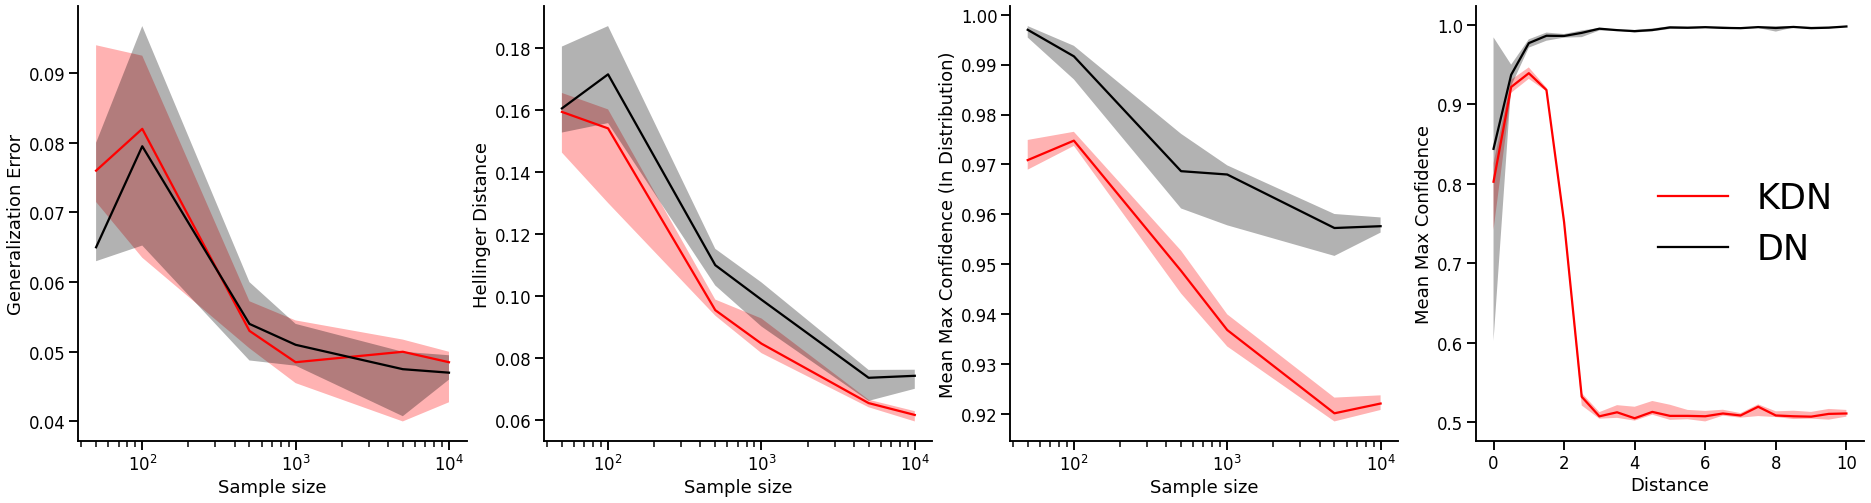

In [12]:
sample_size = [50, 100, 500, 1000, 5000, 10000]

sns.set_context('talk')
fig, ax = plt.subplots(1,4, figsize=(32,8))

ax[0].plot(sample_size, df['error_kdn_med'], c="r", label='KDN')
ax[0].plot(sample_size, df['error_dn_med'], c="k", label='DN')

ax[0].fill_between(sample_size, df['error_kdn_25'], df['error_kdn_75'], facecolor='r', alpha=.3)
ax[0].fill_between(sample_size, df['error_dn_25'], df['error_dn_75'], facecolor='k', alpha=.3)

ax[0].set_xscale('log')
ax[0].set_xlabel('Sample size')
ax[0].set_ylabel('Generalization Error')

right_side = ax[0].spines["right"]
right_side.set_visible(False)
top_side = ax[0].spines["top"]
top_side.set_visible(False)




ax[1].plot(sample_size, df['hellinger_kdn_med'], c="r", label='KDN')
ax[1].plot(sample_size, df['hellinger_dn_med'], c="k", label='DN')

ax[1].fill_between(sample_size, df['hellinger_kdn_25'], df['hellinger_kdn_75'], facecolor='r', alpha=.3)
ax[1].fill_between(sample_size, df['hellinger_dn_25'], df['hellinger_dn_75'], facecolor='k', alpha=.3)

ax[1].set_xscale('log')
ax[1].set_xlabel('Sample size')
ax[1].set_ylabel('Hellinger Distance')

right_side = ax[1].spines["right"]
right_side.set_visible(False)
top_side = ax[1].spines["top"]
top_side.set_visible(False)




ax[2].plot(sample_size, df['mmcIn_kdn_med'], c="r", label='KDN')
ax[2].plot(sample_size, df['mmcIn_dn_med'], c="k", label='DN')

ax[2].fill_between(sample_size, df['mmcIn_kdn_25'], df['mmcIn_kdn_75'], facecolor='r', alpha=.3)
ax[2].fill_between(sample_size, df['mmcIn_dn_25'], df['mmcIn_dn_75'], facecolor='k', alpha=.3)

ax[2].set_xscale('log')
ax[2].set_xlabel('Sample size')
ax[2].set_ylabel('Mean Max Confidence (In Distribution)')

right_side = ax[2].spines["right"]
right_side.set_visible(False)
top_side = ax[2].spines["top"]
top_side.set_visible(False)


r = np.arange(0,10.5,.5)
ax[3].plot(r, df['mmcOut_kdn_med'], c="r", label='KDN')
ax[3].plot(r, df['mmcOut_dn_med'], c="k", label='DN')

ax[3].fill_between(r, df['mmcOut_kdn_25'], df['mmcOut_kdn_75'], facecolor='r', alpha=.3)
ax[3].fill_between(r, df['mmcOut_dn_25'], df['mmcOut_dn_75'], facecolor='k', alpha=.3)

#ax[3].set_xscale('log')
ax[3].set_xlabel('Distance')
ax[3].set_ylabel('Mean Max Confidence')

ax[3].legend(fontsize=35, frameon=False)

right_side = ax[3].spines["right"]
right_side.set_visible(False)
top_side = ax[3].spines["top"]
top_side.set_visible(False)

### OOD detection metrics

In [15]:
def fpr_at_95_tpr(conf_t, conf_f):
    TPR = 95
    PERC = np.percentile(conf_t, 100-TPR)
    FP = np.sum(conf_f >=  PERC)
    FPR = np.sum(conf_f >=  PERC)/len(conf_f)
    return FPR, PERC

In [16]:
sample = 10000
reps = 10
n_test = 1000
true_labels = np.hstack((np.ones(n_test, ), np.zeros(n_test, )))

roc_dn = []
roc_kdn = []

fpr_dn = []
fpr_kdn = []
reps_list = []

for ii in range(reps):
    X, y = generate_gaussian_parity(sample)
    X_test, y_test = generate_gaussian_parity(n_test)
    X_ood = generate_ood_samples(n_test)

    
    nn = getNN(input_size=2, num_classes=2)
    history = nn.fit(X, keras.utils.to_categorical(y), **fit_kwargs)
    model_kdn = kdn(k=.1, network=nn)
    model_kdn.fit(X, y)

    dn_in_conf = np.max(model_kdn.network.predict(X_test), axis=1)
    dn_out_conf = np.max(model_kdn.network.predict(X_ood), axis=1)
    dn_conf = np.hstack((dn_in_conf, dn_out_conf))
    roc_dn.append(
        roc_auc_score(true_labels, dn_conf)
    )
    fpr_dn.append(
        fpr_at_95_tpr(dn_in_conf, dn_out_conf)
    )
    
    

    kdn_in_conf = np.max(model_kdn.predict_proba(X_test), axis=1)
    kdn_out_conf = np.max(model_kdn.predict_proba(X_ood), axis=1)
    kdn_conf = np.hstack((kdn_in_conf, kdn_out_conf))
    roc_kdn.append(
        roc_auc_score(true_labels, kdn_conf)
    )
    fpr_kdn.append(
        fpr_at_95_tpr(kdn_in_conf, kdn_out_conf)
    )

    reps_list.append(ii)

2023-02-20 22:20:46.980717: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


Epoch 81: early stopping
32/32 [==============================] - 0s 2ms/step


2023-02-20 22:30:14.538187: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2023-02-20 22:30:15.320386: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


Epoch 40: early stopping
32/32 [==============================] - 0s 2ms/step


2023-02-20 22:39:09.687172: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2023-02-20 22:39:10.476774: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


Epoch 35: early stopping
32/32 [==============================] - 0s 2ms/step


2023-02-20 22:48:04.195296: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2023-02-20 22:48:04.985038: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


Epoch 84: early stopping
27/32 [========================>.....] - ETA: 0s

2023-02-20 22:57:38.071863: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


32/32 [==============================] - 0s 2ms/step


2023-02-20 22:57:38.872188: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


Epoch 28: early stopping
27/32 [========================>.....] - ETA: 0s

2023-02-20 23:06:36.629528: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


32/32 [==============================] - 0s 2ms/step


2023-02-20 23:06:37.435208: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


Epoch 30: early stopping
32/32 [==============================] - 0s 2ms/step


2023-02-20 23:15:45.459249: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2023-02-20 23:15:46.259121: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


Epoch 42: early stopping
32/32 [==============================] - 0s 2ms/step


2023-02-20 23:24:57.547068: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2023-02-20 23:24:58.356632: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


Epoch 51: early stopping
28/32 [=========================>....] - ETA: 0s

2023-02-20 23:34:01.751608: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


32/32 [==============================] - 0s 2ms/step


2023-02-20 23:34:02.550330: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


Epoch 66: early stopping
28/32 [=========================>....] - ETA: 0s

2023-02-20 23:43:26.795498: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


32/32 [==============================] - 0s 2ms/step


2023-02-20 23:43:27.598972: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


Epoch 83: early stopping
 1/32 [..............................] - ETA: 0s

2023-02-20 23:53:49.430368: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


32/32 [==============================] - 0s 2ms/step


In [17]:
# obtain the AUROC and FPR@95 scores

# AUROC
print("KDN AUROC = {:.3f} +/- {:.3f}".format(np.mean(roc_kdn), np.std(roc_kdn)))
print("DN AUROC = {:.3f} +/- {:.3f}".format(np.mean(roc_dn), np.std(roc_dn)))

KDN AUROC = 0.969 +/- 0.005
DN AUROC = 0.223 +/- 0.027


In [18]:
# FPR@95
print("KDN FPR@95 = {:.3f} +/- {:.3f}".format(np.mean(fpr_kdn), np.std(fpr_kdn)))
print("DN FPR@95 = {:.3f} +/- {:.3f}".format(np.mean(fpr_dn), np.std(fpr_dn)))

KDN FPR@95 = 0.457 +/- 0.337
DN FPR@95 = 0.910 +/- 0.074


In [12]:
polytope_ids

array([331948751338312552385903309491561272084836295551736852410569684930431463267696262786520903771401030582904683889688626030314281055369842223714137939973175912065430213406815310360824663108201054454774402724772833845308598681176097069711100787445173269371461426089443444142279051819433845905824445113865809843774474707298370314913485914150931971080740798202120461070010989401048547798834493239898697957732281641913088020716698076601753755572818916753049820893624881702172842736564145797162693627578923239663548677773273823194261473872094670691007090815464587704846219771631206974729788691862592872977069823051482640496781783882662224668392796965298663817377929394746376283827987814220291330323985240721996704516232094873253518536168342475618539588340729529798840810110819511680391531953184677936002255392955827737420582261930250613474681210362201051362112368229096344648136223691043023329536935736499876905277668628426011729757942997862112653739661707484424702277945848248039321052252490464512776

In [10]:
model_kdn.polytope_cov

[array([0.0001, 0.0001]),
 array([0.0001, 0.0001]),
 array([0.0001, 0.0001]),
 array([0.0001, 0.0001]),
 array([0.0001, 0.0001]),
 array([0.0001, 0.0001]),
 array([0.0001, 0.0001]),
 array([0.0001, 0.0001]),
 array([0.0001, 0.0001]),
 array([0.0001, 0.0001]),
 array([0.0001, 0.0001]),
 array([0.0001, 0.0001]),
 array([0.0001, 0.0001]),
 array([0.0001, 0.0001]),
 array([0.0001, 0.0001]),
 array([0.0001, 0.0001]),
 array([0.0001, 0.0001]),
 array([0.0001, 0.0001]),
 array([0.0001, 0.0001]),
 array([0.0001, 0.0001]),
 array([0.0001, 0.0001]),
 array([0.0001, 0.0001]),
 array([0.0001, 0.0001]),
 array([0.0001, 0.0001]),
 array([0.0001, 0.0001]),
 array([0.0001, 0.0001]),
 array([0.0001, 0.0001]),
 array([0.0001, 0.0001]),
 array([0.0001, 0.0001]),
 array([0.0001, 0.0001]),
 array([0.0001, 0.0001]),
 array([0.0001, 0.0001]),
 array([0.0001, 0.0001]),
 array([0.0001, 0.0001]),
 array([0.0001, 0.0001]),
 array([0.0001, 0.0001]),
 array([0.0001, 0.0001]),
 array([0.0001, 0.0001]),
 array([0.00